In [10]:
# ===== Block 1: Install (if needed) & Imports =====

# If you're in Colab, you can uncomment this:
# !pip install networkx numpy pandas matplotlib scikit-learn

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import gzip
import random

# For consistent results
random.seed(42)
np.random.seed(42)


In [5]:
# ===== Block 2: Load Dataset (facebook_combined.txt.gz) =====

# Change this to your actual file name if different
file_path = "facebook_combined.txt.gz"

edges = []
with gzip.open(file_path, "rt") as f:
    for line in f:
        u, v = map(int, line.strip().split())
        edges.append((u, v))

print("Total edges loaded:", len(edges))


Total edges loaded: 88234


In [11]:
# ===== Block 3: Build Graph =====

G = nx.Graph()
G.add_edges_from(edges)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 4039
Number of edges: 88234


In [12]:
# ===== Block 4: Compute Graph Metrics (Baseline) =====

deg = dict(G.degree())
clust = nx.clustering(G)
# Approximate betweenness for speed
centrality = nx.betweenness_centrality(G, k=200, seed=42)

nodes_list = list(G.nodes())

metrics_df = pd.DataFrame({
    "node": nodes_list,
    "degree": [deg[n] for n in nodes_list],
    "clustering": [clust[n] for n in nodes_list],
    "centrality": [centrality[n] for n in nodes_list]
})

metrics_df.head()


,node,degree,clustering,centrality
0,0,347,0.041962,1.474133e-01
1,1,17,0.419118,1.560310e-06
2,2,10,0.888889,1.548563e-07
3,3,17,0.632353,2.408875e-06
4,4,10,0.866667,0.000000e+00


In [13]:
# ===== Block 5: Simulate Bot Nodes =====

num_bots = 300
bots = set(random.sample(nodes_list, num_bots))

metrics_df["label"] = metrics_df["node"].apply(lambda n: 1 if n in bots else 0)
print(metrics_df["label"].value_counts())
metrics_df.head()


label
0    3739
1     300
Name: count, dtype: int64


,node,degree,clustering,centrality,label
0,0,347,0.041962,1.474133e-01,0
1,1,17,0.419118,1.560310e-06,0
2,2,10,0.888889,1.548563e-07,1
3,3,17,0.632353,2.408875e-06,0
4,4,10,0.866667,0.000000e+00,0


In [14]:
# ===== Block 6: Baseline Bot Detection (No Attack) =====

X = metrics_df[["degree", "clustering", "centrality"]]
y = metrics_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("===== BASELINE PERFORMANCE (NO ATTACK) =====")
print(classification_report(y_test, y_pred))

baseline_acc = accuracy_score(y_test, y_pred)
print("Baseline Accuracy:", baseline_acc)


===== BASELINE PERFORMANCE (NO ATTACK) =====
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1126
           1       0.00      0.00      0.00        86

    accuracy                           0.92      1212
   macro avg       0.46      0.50      0.48      1212
weighted avg       0.86      0.92      0.89      1212

Baseline Accuracy: 0.9232673267326733


In [15]:
# ===== Block 7: Structural Evasion Attack (Modify Graph Structure of Bots) =====

def structural_evasion(G, bot_nodes, k=5, top_hubs=50):
    """
    Connect each bot to k high-degree hub nodes to make them look more 'normal'.
    """
    # Get top high-degree nodes (hubs)
    hubs = sorted(G.degree(), key=lambda x: x[1], reverse=True)[:top_hubs]
    hub_nodes = [h[0] for h in hubs]

    for b in bot_nodes:
        for _ in range(k):
            h = random.choice(hub_nodes)
            G.add_edge(b, h)

# Copy original graph and apply evasion
G_evasion = G.copy()
structural_evasion(G_evasion, bots)

print("Evasion graph - nodes:", G_evasion.number_of_nodes())
print("Evasion graph - edges:", G_evasion.number_of_edges())


Evasion graph - nodes: 4039
Evasion graph - edges: 89581


In [16]:
# ===== Block 8: Recompute Metrics & Train After Structural Evasion =====

deg2 = dict(G_evasion.degree())
clust2 = nx.clustering(G_evasion)
cent2 = nx.betweenness_centrality(G_evasion, k=200, seed=42)

nodes_evasion = list(G_evasion.nodes())

metrics_evasion = pd.DataFrame({
    "node": nodes_evasion,
    "degree": [deg2[n] for n in nodes_evasion],
    "clustering": [clust2[n] for n in nodes_evasion],
    "centrality": [cent2[n] for n in nodes_evasion],
    "label": [1 if n in bots else 0 for n in nodes_evasion]
})

X2 = metrics_evasion[["degree", "clustering", "centrality"]]
y2 = metrics_evasion["label"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.3, random_state=42
)

clf2 = RandomForestClassifier(n_estimators=200, random_state=42)
clf2.fit(X2_train, y2_train)
y2_pred = clf2.predict(X2_test)

print("===== AFTER STRUCTURAL EVASION ATTACK =====")
print(classification_report(y2_test, y2_pred))

evasion_acc = accuracy_score(y2_test, y2_pred)
print("Accuracy after Structural Evasion:", evasion_acc)


===== AFTER STRUCTURAL EVASION ATTACK =====
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1126
           1       0.89      0.84      0.86        86

    accuracy                           0.98      1212
   macro avg       0.94      0.91      0.93      1212
weighted avg       0.98      0.98      0.98      1212

Accuracy after Structural Evasion: 0.981023102310231


In [17]:
# ===== Block 9: Graph Poisoning Attack =====

def graph_poison(G, bot_nodes, poison_edges=500):
    """
    Add many random edges from bots to random nodes in the graph.
    This corrupts structural statistics and 'poisons' the graph.
    """
    nodes = list(G.nodes())
    for _ in range(poison_edges):
        u = random.choice(list(bot_nodes))
        v = random.choice(nodes)
        G.add_edge(u, v)

# Copy original graph and apply poisoning
G_poison = G.copy()
graph_poison(G_poison, bots, poison_edges=500)

print("Poisoned graph - nodes:", G_poison.number_of_nodes())
print("Poisoned graph - edges:", G_poison.number_of_edges())


Poisoned graph - nodes: 4039
Poisoned graph - edges: 88728


In [22]:
# ===== Block 10: Recompute Metrics & Train After Graph Poisoning =====

deg3 = dict(G_poison.degree())
clust3 = nx.clustering(G_poison)
cent3 = nx.betweenness_centrality(G_poison, k=200, seed=42)

nodes_poison = list(G_poison.nodes())

metrics_poison = pd.DataFrame({
    "node": nodes_poison,
    "degree": [deg3[n] for n in nodes_poison],
    "clustering": [clust3[n] for n in nodes_poison],
    "centrality": [cent3[n] for n in nodes_poison],
    "label": [1 if n in bots else 0 for n in nodes_poison]
})

X3 = metrics_poison[["degree", "clustering", "centrality"]]
y3 = metrics_poison["label"]

X3_train, X3_test, y3_train, y3_test = train_test_split(
    X3, y3, test_size=0.3, random_state=42
)

clf3 = RandomForestClassifier(n_estimators=200, random_state=42)
clf3.fit(X3_train, y3_train)
y3_pred = clf3.predict(X3_test)

print("===== AFTER GRAPH POISONING ATTACK =====")
print(classification_report(y3_test, y3_pred))

poison_acc = accuracy_score(y3_test, y3_pred)
print("Accuracy after Graph Poisoning:", poison_acc)


===== AFTER GRAPH POISONING ATTACK =====
              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1126
           1       0.30      0.10      0.16        86

    accuracy                           0.92      1212
   macro avg       0.62      0.54      0.56      1212
weighted avg       0.89      0.92      0.90      1212

Accuracy after Graph Poisoning: 0.9191419141914191


In [23]:
# ===== Block 11: Compare Baseline vs Evasion vs Poisoning =====

results_df = pd.DataFrame({
    "Condition": ["Baseline", "Structural Eva|sion", "Graph Poisoning"],
    "Accuracy": [baseline_acc, evasion_acc, poison_acc]
})

print(results_df)


             Condition  Accuracy
0             Baseline  0.923267
1  Structural Eva|sion  0.981023
2      Graph Poisoning  0.919142


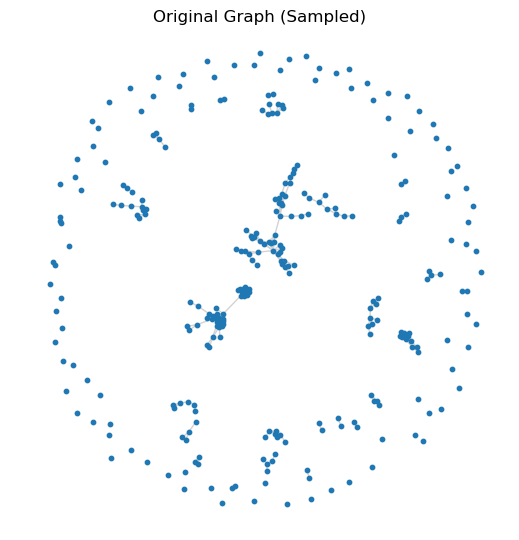

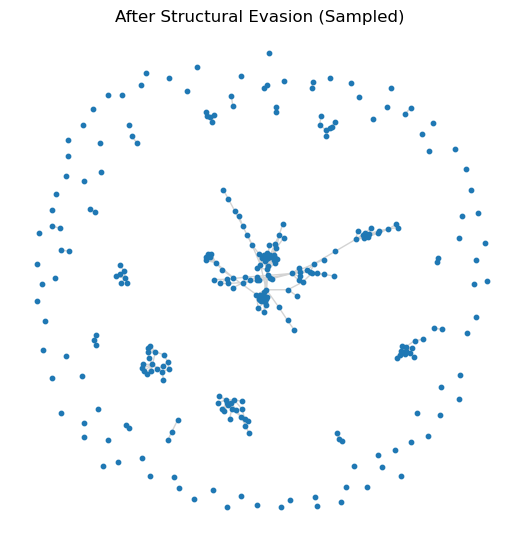

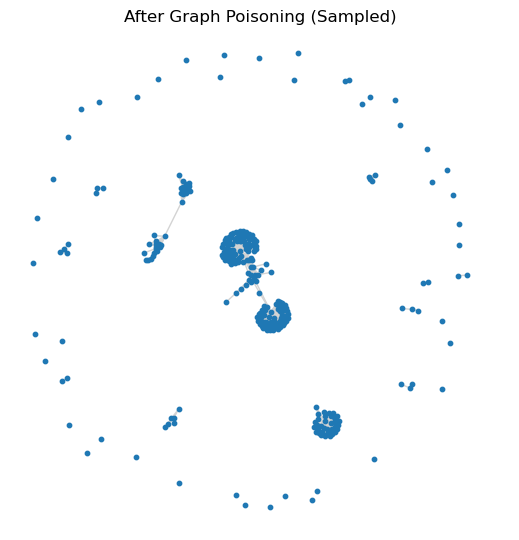

In [24]:
# ===== Block 12: Visualize Graphs (Optional) =====
# On the full Facebook graph this can be slow.
# You can sample a subset of nodes for clearer plots.

def draw_sampled_graph(G, title, sample_size=300):
    sub_nodes = random.sample(list(G.nodes()), min(sample_size, G.number_of_nodes()))
    subG = G.subgraph(sub_nodes)
    plt.figure(figsize=(5, 5))
    pos = nx.spring_layout(subG, seed=42)
    nx.draw(subG, pos, node_size=10, edge_color='lightgray')
    plt.title(title)
    plt.axis('off')
    plt.show()

draw_sampled_graph(G, "Original Graph (Sampled)")
draw_sampled_graph(G_evasion, "After Structural Evasion (Sampled)")
draw_sampled_graph(G_poison, "After Graph Poisoning (Sampled)")
